## Implementing the collaborative filtering using deep learning
* Randomly Initialise Parameters — these will be the latent factors that help predict whether someone will like a movie.
* Calculate Predictions — this is done by taking the matrix dot product of the movie and user matrices. An example would be if a user’s likening to international films is high, and a movie is foreign; the product of the two will be large and, that movie will rank higher for that user.
* note: This approach could be used for prediction but is very inefficient as it requires a vector to be created and stored for each prediction.

In [4]:
#libreries
from fastai.collab import *
from fastai.tabular.all import *
from fastai import *
from fastai.metrics import *
from fastai.callback.tracker import *

#import acc from fastai.metrics
from fastai.metrics import accuracy, Precision, Recall
#from fastbook import *
import pandas as pd
import numpy as np
set_seed(42)

In [5]:
df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
df.head()

,userId,wine,rate
0,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso,3
1,df904a46-c461-4233-9d44-6ac11a8bbddc,Astrale,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3
3,bc79b0e3-064d-4240-86de-e86499f577e8,3/11 Syrah and blend #4,3
4,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso Classico Superiore Pojega,4


In [6]:
# # #importing directly the confusion matrix
# # user_features_df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/user_features_df.csv')
# # user_features_df

# #importing the user,movie,rating dataframe
# #we drop a column that was added by mistake by the system
# df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
# df.head()
# # df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/df.csv').drop('Unnamed: 0', axis=1)
# # df.tail()

In [7]:
#we create a dataloader
#we pass the title of the movie and not the movie id
dls = CollabDataLoaders.from_df(df, user_name='userId',item_name='wine', bs=64)
#we can see the batch
dls.show_batch()

,userId,wine,rate
0,5bce85c2-b3c7-401f-b77b-992df3544479,Olmera,1
1,09f6ca6e-905f-4afd-bab2-d928fe046f18,Perlugo Extra Brut,1
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Tignanello,4
3,441ac739-42f8-48d2-9526-fdedf2d4852f,Bollicina,3
4,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Blanc del Noirs,2
5,dd7e04c1-987c-4520-9ab5-c90e86b7dfe1,Les Folastries Gewürztraminer,4
6,838e0d9d-27e9-4f89-9eab-ba2c2f412759,Red (Winemaker's Blend),1
7,5bce85c2-b3c7-401f-b77b-992df3544479,Pinot noir San Mischael eppan,3
8,cabb87a0-6498-438a-beb7-676f72bddd09,Sauvignon Blanc,4
9,13016d41-00bd-411c-83f5-2b95691696b7,Pinot Grigio,4


In [8]:
#CALCULATE PREDICTIONS USING MATRIX MULTIPLICATION

#we create a matrix with the user features
n_users = len(dls.classes['userId']) #the number of user is the lenght of how many users
#we create a matrix with the movie features
n_movies = len(dls.classes['wine']) #the number of movies is the lenght of how many movies
#we choose the number of factors
n_factors = 5 

#we create a random matrix with the user features(embeddings)
#userFactors = (numberOfUsers x 5)
user_factors = torch.randn(n_users, n_factors)
#we create a random matrix with the movie features(embeddings)
#movieFactors = (numberOfMovies x 5)
movie_factors = torch.randn(n_movies, n_factors)

##########################################
#To calculate the result for a particular movie and user combination, 
#we have to look up the index of the movie in our movie latent factor matrix and
#the index of the user in our user latent factor matrix; 
#then we can do our dot product between the two latent factor vectors

# Create a function that takes the user id and the movie title to make a prediction
def oneHotPredict(userId, title):
    '''In the oneHotPredict function, 
    we use the indices of the user and movie in the embedding matrices
    to look up the corresponding embeddings.
    ----
    We calculate the prediction by taking the dot product
    (element-wise multiplication and then sum) of the user and wine embeddings.
    '''
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]
    
    user_embedding = user_factors[userIdx]
    movie_embedding = movie_factors[movie_idx]
    
    prediction = (user_embedding * movie_embedding).sum()
    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

In [9]:
# Prediction for user 9 and the movie 'Toy Story (1995)'
prediction = oneHotPredict('13016d41-00bd-411c-83f5-2b95691696b7', 'Pinot Grigio')
#print(f'Predicted rating for user 9 and Toy Story (1995): {prediction:.2f}')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'Pinot Grigio': -0.61


## Matrix factorization
* A better approach

In [10]:
def create_params(size):
    """
      Pass tensor shape
      Returns normalised model parameters
    """
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    """
    Model architecture for collaborative filtering
    """
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        """
        Initialises model with parameters
        :param n_users: number of users
        :param n_movies: number of movies
        :param n_factors: number of factors
        :param y_range: sigmoid limit
        """
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        """
        Applies a forward pass on the dataset passed
        :param x: data as DataLoaders obj
        :return: predictions in sigmoid range (tensor)
        """
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
        return sigmoid_range(res, *self.y_range)

In [11]:
#good model
#Working perfectly without cross validation
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
#wd = weight decay (L2 regularization)
learn.fit_one_cycle(10, 0.05, wd=0.1)
# # acc = 79.00%, train_loss = 0.134415, valid_loss = 0.236329, mse = 0.236329, rmse = 0.486136, mae = 0.268503

# #This model generalize good
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
# #wd = weight decay (L2 regularization)
# learn.fit_one_cycle(10, 0.003, wd=0.1)
# # acc = 68.24% , train_loss = 0.239520, valid_loss = 0.418527, mse = 0.418527, rmse = 0.646936, mae = 0.398856

epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.928513,1.896396,1.896396,1.377097,1.195578,00:00
1,1.676263,1.655080,1.655080,1.286499,1.083704,00:00
2,1.167899,1.782437,1.782437,1.335080,1.097166,00:00
3,0.968151,1.632990,1.632990,1.277885,1.067597,00:00
4,0.843359,1.589879,1.589879,1.260904,1.029890,00:00
5,0.714639,1.603542,1.603542,1.266311,1.028158,00:00
6,0.587472,1.597991,1.597991,1.264117,1.025193,00:00
7,0.472519,1.587365,1.587365,1.259907,1.015141,00:00
8,0.378787,1.585860,1.585860,1.259309,1.011494,00:00
9,0.306723,1.585832,1.585832,1.259298,1.011313,00:00


SuggestedLRs(valley=0.005248074419796467)

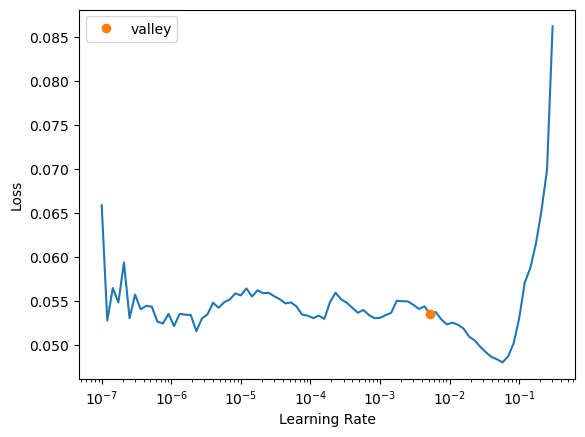

In [12]:
learn.lr_find()

In [13]:
#import torch.nn as nn
#Recommendations
def recommends(fav_movie, top_n=5):
    movie_factors = learn.model.movie_factors
    #we look up the movie in the movie factors
    idx = dls.classes['wine'].o2i[fav_movie]
    #find the movie with minimum distance
    distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
    #we sort the movies by distance
    idx = distances.argsort(descending=True)[1:top_n+1]
    #we return the movies
    recommended_movies = [dls.classes['wine'][i] for i in idx]
    return recommended_movies

recommended_movies = recommends('Pinot Grigio')
print("Recommended movies:")
for movie in recommended_movies:
    print(movie)

Recommended movies:
Bortolomiol Vintage Extra Dry Millesimato
Chartreuse de Bonpas Réserve
Tenuta Guado al Tasso Il Bruciato Bolgheri
Piceno Bacchus
The long coast cabernet sauvignon


In [14]:
#def prediction for a user
def prediction_user_like(userId, title):
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]

    # Make a prediction using the model's forward method
    prediction = learn.model.forward(tensor([[userIdx, movie_idx]])).item()

    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

prediction = prediction_user_like('13016d41-00bd-411c-83f5-2b95691696b7', 'chardonnay')
prediction = prediction_user_like(50, 'cabernet sauvignon')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'chardonnay': 3.05
Predicted rating for user '50' and 'cabernet sauvignon': 2.76


In [15]:
# Show 20 rows of results
learn.show_results(n=20)

,userId,wine,rate,rate_pred
0,17,4,3,3.374868
1,5,121,4,3.081343
2,32,522,1,2.425205
3,148,247,5,4.809047
4,66,371,4,3.263105
5,141,569,1,2.680267
6,60,96,4,3.957231
7,148,176,3,3.144978
8,53,279,3,3.052802


In [16]:
g = df.groupby('wine')['rate'].count()
top_wines = g.sort_values(ascending=False).index.values[:50]
top_wines[:10]

array(["Moscata D'Asti Casaniere", 'Morellino di Scansano 2021',
       'Morellino di Scansano DOCG terre di talamo', 'Montefalco Rosso',
       'Nativi Gewürtztraminer', 'Vitovska acciaio', 'Chardonnay',
       "Nebbiolo d'Alba", 'Amarone',
       'Nespolino Rubicone Sangiovese - Merlot'], dtype=object)

In [17]:
from fastai.metrics import rmse

# Get predictions and targets
preds, targs = learn.get_preds()

# Calculate RMSE
error = rmse(preds, targs)
print(f'RMSE: {error}')

#MSE
error2 = mse(preds, targs)
print(f'MSE: {error2}')

#MAE
error3 = mae(preds, targs)
print(f'MAE: {error3}')

print(preds.shape)
print(targs.shape)

#transform the trags since they were a 2d tensor
targs = targs.squeeze()

#we create a dataframe with the predictions and the targets
df = pd.DataFrame({ 'targets': targs,'predictions': preds})
df.head(20)

#check the error
df['error'] = df['predictions'] - df['targets']


#print the error of the model
print(f"The error is : {df['error'].abs().mean()}")

df

RMSE: 1.2592980861663818
MSE: 1.5858315229415894
MAE: 1.0113133192062378
torch.Size([190])
torch.Size([190, 1])
The error is : 1.0113133192062378


,targets,predictions,error
0,5,3.363461,-1.636539
1,1,2.923729,1.923729
2,4,3.080818,-0.919182
3,2,2.574033,0.574033
4,3,3.505707,0.505707
...,...,...,...
185,4,3.258756,-0.741244
186,2,3.065582,1.065582
187,4,3.957231,-0.042769
188,5,2.862940,-2.137060


In [18]:
#sort by best predictions and worst predictions
#sort col error from 0 to 5(-5)

df['abs_error'] = df['error'].abs()
best_predictions = df.sort_values(by='abs_error', ascending=True)
worst_predictions = df.sort_values(by='error', ascending=False)

#best predictions
best_predictions.head(10)

,targets,predictions,error,abs_error
14,3,2.999465,-0.000535,0.000535
179,3,2.999139,-0.000861,0.000861
49,3,3.009458,0.009458,0.009458
7,3,3.010015,0.010015,0.010015
42,3,2.974826,-0.025174,0.025174
56,3,3.030901,0.030901,0.030901
78,3,2.964637,-0.035363,0.035363
22,3,2.963665,-0.036335,0.036335
96,1,0.960906,-0.039094,0.039094
187,4,3.957231,-0.042769,0.042769


In [19]:
worst_predictions.head(10)

,targets,predictions,error,abs_error
61,1,4.997308,3.997308,3.997308
37,1,3.844846,2.844846,2.844846
60,1,3.380980,2.380980,2.380980
127,1,3.336554,2.336554,2.336554
39,1,3.325145,2.325145,2.325145
139,1,3.223457,2.223457,2.223457
108,1,3.109948,2.109948,2.109948
118,1,3.102956,2.102956,2.102956
38,1,3.093233,2.093233,2.093233
132,1,3.018680,2.018680,2.018680


In [20]:
def get_accuracy(df):
    # Count correct predictions
    correct = 0
    for _, row in df.iterrows():
        if round(row['predictions']) == round(row['targets']):
            correct += 1

    # Compute accuracy
    accuracy_percentage = correct / len(df)
    return accuracy_percentage * 100

# Get accuracy
accuracy = get_accuracy(df)
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 27.89%


In [21]:
preds, targs = learn.get_preds()

# Now you can check their shapes
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([190])
Targets shape: torch.Size([190, 1])


In [22]:
# Remove the extra dimension from targets
targs = targs.squeeze()

# Now the shapes should match
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([190])
Targets shape: torch.Size([190])


In [23]:
# Assuming `dls` is your DataLoader
for i, batch in enumerate(dls.valid):
    x, y = batch
    print(f'Batch {i+1}: {x.shape[0]}')

# Check the shape of predictions and targets
print(f'Predictions: {preds.shape[0]}')
print(f'Targets: {targs.shape[0]}')

Batch 1: 64
Batch 2: 64
Batch 3: 62
Predictions: 190
Targets: 190


In [24]:
print(f'Predictions: {preds.shape}')
print(f'Targets: {targs.shape}')

Predictions: torch.Size([190])
Targets: torch.Size([190])
